# Charge health insurance prediction
We begin loading the modules that we will use

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import plotly.express as px
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
import shap 

Now we load the data and see a bit of it 

In [2]:
DF = pd.read_csv("Health_insurance.csv")
DF.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Is useful to see the information about the data, and if is necesary, clean it.

In [3]:
DF.info()
DF.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We analyze the proportion of smoker people and the distribution of the gender (binary in this ocassion)

In [4]:
import plotly.express as px

df = px.data.tips()
fig = px.histogram(DF,
    x="sex",
    color="smoker",
    title= "Number of smokers"
)
fig.show()


To use the smoker and gender information to the model we need to assign numerical values istead of strings

In [5]:
le = preprocessing.LabelEncoder() #label encoding from sklearn
le.fit(DF.sex)
DF['sex'] = le.transform(DF.sex)
le.fit(DF.smoker)
DF["smoker"] = le.transform(DF.smoker)
#DF = DF.drop("categorical_label",axis=1)
DF.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


Let's se relevant location distributionfrom where are the people in the data set we could do a pie chart as follows

In [6]:
#or using plotly
import plotly.express as px
pie = DF["region"].value_counts()
regions = pie.index
population = pie.values
fig = px.pie(DF, values=population, names=regions)
fig.show()

Now we will obtain the correlation matrix, this helps to see how much our features and the label are correlated as the name of the matrix says

In [7]:
Corr = DF.corr()

For a better visualization we use a heatmap

Text(0.5, 1.0, 'Health Inssurance Correlation Heatmap')

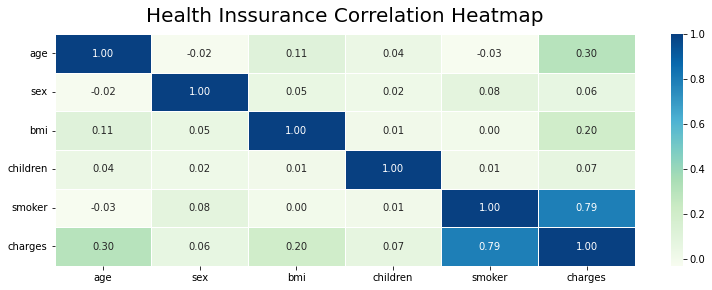

In [8]:
f, ax =plt.subplots(figsize=(13,4))
hm = sns.heatmap(
    round(Corr,2),
    annot=True,
    ax=ax,
    cmap="GnBu",
    fmt='.2f',
    linewidths=0.7
)
f.subplots_adjust(top=0.93)
#t = f.suptitle("Inssurance Health Correlation Heatmap", fontsize=14)
hm.set_title('Health Inssurance Correlation Heatmap', fontdict={'fontsize':20}, pad=12)


## Let's work with the model
We transform our data set into an array with the relevant data we will need and them split it to get the train set and the test set.

In [9]:
X = np.array(DF[["age", "sex", "bmi", "smoker"]])
y = np.array(DF["charges"])

X100 = shap.utils.sample(X, 100)

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

X100.shape

(100, 4)

We call the model, in this case an XGBoost regressor, we train it, test it and se the RMSE

In [10]:
model = xgb.XGBRegressor()

model.fit(xtrain,ytrain)
prediction = model.predict(xtest)
rmse = np.sqrt(MSE(ytest, prediction))
print("RMSE : % f" %(rmse))

RMSE :  5145.402832


## Now to see how the model works we use Shapley values

Exact explainer: 1339it [00:13, 19.30it/s]                           


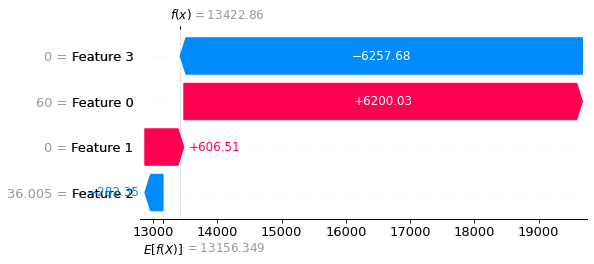

In [12]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)
sample_ind = 20 

shap.plots.waterfall(shap_values[sample_ind], max_display=14)